In [1]:
# pacotes e configurações gerais
import pandas as pd
import matplotlib as ml
import numpy as np
import math as mt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',20)

In [2]:
# Importação dos dados e verificação dos dados
data=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/daily-minimum-temperatures.csv")
data.dtypes
data=data.sort_values('Date')
data['Date'] = pd.to_datetime(data['Date'])
data['Year']=data['Date'].dt.year
data=data[['Year','Date','Temp']]
print(data.head(5))
print(data.tail(5))
print(data.describe())

   Year       Date  Temp
0  1981 1981-01-01  20.7
1  1981 1981-01-02  17.9
2  1981 1981-01-03  18.8
3  1981 1981-01-04  14.6
4  1981 1981-01-05  15.8
      Year       Date  Temp
3645  1990 1990-12-27  14.0
3646  1990 1990-12-28  13.6
3647  1990 1990-12-29  13.5
3648  1990 1990-12-30  15.7
3649  1990 1990-12-31  13.0
              Year         Temp
count  3650.000000  3650.000000
mean   1985.500000    11.177753
std       2.872675     4.071837
min    1981.000000     0.000000
25%    1983.000000     8.300000
50%    1985.500000    11.000000
75%    1988.000000    14.000000
max    1990.000000    26.300000


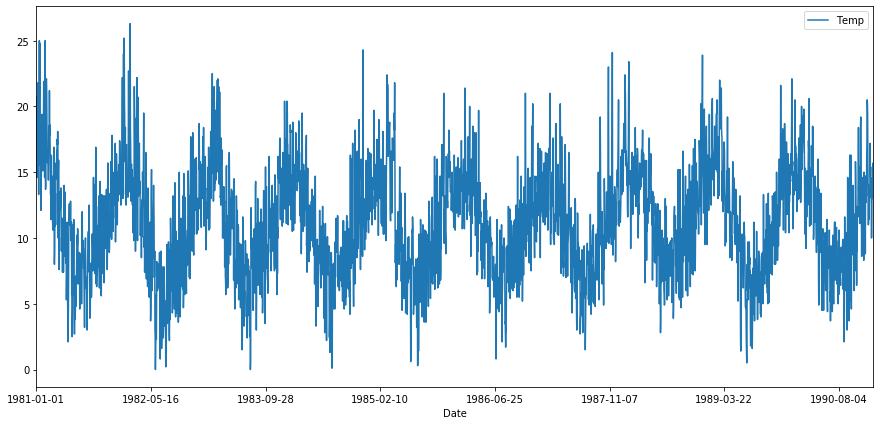

In [4]:
# gráfico com os dados
plot=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/daily-minimum-temperatures.csv",header=0,index_col=0)
plot.plot(figsize=(15,7))
ml.rcParams.update({'font.size': 10})
ml.pyplot.show()



In [5]:
#Transforma os dados em um problema supervisionado
data_windowed=data.copy()
data_windowed['C']=1
for k in range(1,31) :
     colum_name='T-'+str(k)
     data_windowed[colum_name]=data['Temp'].shift(k)
#elimina os 30 primeiros dias q não há como prever
data_windowed = data_windowed.iloc[30:]
data_windowed.describe()
data_windowed.head()

,Year,Date,Temp,C,T-1,T-2,T-3,T-4,T-5,T-6,...,T-21,T-22,T-23,T-24,T-25,T-26,T-27,T-28,T-29,T-30
30,1981,1981-01-31,15.4,1,15.1,15.5,17.2,19.4,18.7,16.5,...,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
31,1981,1981-02-01,15.3,1,15.4,15.1,15.5,17.2,19.4,18.7,...,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
32,1981,1981-02-02,18.8,1,15.3,15.4,15.1,15.5,17.2,19.4,...,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
33,1981,1981-02-03,21.9,1,18.8,15.3,15.4,15.1,15.5,17.2,...,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
34,1981,1981-02-04,19.9,1,21.9,18.8,15.3,15.4,15.1,15.5,...,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8


In [6]:
#configuraçõeos do método
ano_teste=1990
atrasos=5
lista_folders=[2]
#gera os dados de treino e teste
data_train=data_windowed[data_windowed['Year']!=ano_teste].copy()
data_test=data_windowed[data_windowed['Year']==ano_teste].copy()
#inicia os testes
for folders in lista_folders:
    #inicializa os parâmetros que vão guardar os resultados
    folder_min=0
    k_min=0
    erro_min=0
    erro_antigo=100000
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for f in range(1,folders+1):
        lenght=len(data_train[data_train['fold']==f])
    linha=0
    resultados=pd.DataFrame(columns=['Atraso','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
    y_tf=data_test.iloc[:,2:3].copy()
    for k in range(1,atrasos+1):
        #dados treino globais
        x_tf=data_test.iloc[:,3:k+4].copy()
        for f in range(1,folders+1):
            linha+=1
            resultados.loc[linha,'Atraso']=k
            resultados.loc[linha,'Folder']=f
            #Dados treino no folder
            x_train=data_train[data_train['fold']!=f]
            x_train=x_train.iloc[:,3:k+4].copy()
            y_train=data_train[data_train['fold']!=f]
            y_train=y_train.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Treino']=len(x_train)
            #Dados teste no folder
            x_valid=data_train[data_train['fold']==f]
            x_valid=x_valid.iloc[:,3:k+4].copy()
            y_valid=data_train[data_train['fold']==f]
            y_valid=y_valid.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Validação']=len(x_valid)
            #calculo da inversa
            xtx=(x_train.transpose()).dot(x_train)
            rank=np.linalg.matrix_rank(xtx.values)
            if rank==(k+1):
                message="Sim"
            else:
                message="Não"
            resultados.loc[linha,'Matrix']=message
            #cálculo do vetor w para regressão
            xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
            w=(xtxinv.dot(x_train.transpose())).dot(y_train)
            #erro treino
            yh_train=x_train.dot(w)
            error_train=mt.sqrt(((yh_train-y_train)**2).mean())
            resultados.loc[linha,'Erro Treino']=error_train
            #erro validação
            yh_valid=x_valid.dot(w)
            error_valid=mt.sqrt(((yh_valid-y_valid)**2).mean())
            resultados.loc[linha,'Erro Validação']=error_valid
            #erro teste
            yh_tf=x_tf.dot(w)
            error_tf=mt.sqrt(((yh_tf-y_tf)**2).mean())
            resultados.loc[linha,'Erro Teste']=error_tf
            
            if error_valid<erro_antigo:
                erro_min=error_valid
                temp_estimada_min=yh_tf.copy()
                folder_min=f
                k_min=k
                erro_antigo=error_valid
# leitura dos resultados
    print(resultados[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
#     print("Relatorio pelo menor erro.")
# #     relatorio pelo melhor preditor de cada k
#     relatorio_lista=[]
#     linha=0
#     for k in range(1,atrasos+1):
#         linha +=1
#         x=resultados[resultados['Atraso']==k].copy()
#         x=x.astype({'Erro Validação':float})
#         linha_dados=x.loc[x['Erro Validação'].idxmin()]
#         relatorio_lista.append(linha_dados.values.tolist())
    
#     relatorio=pd.DataFrame(relatorio_lista,columns=['Atraso','Folder','Dado Treino','Dado Teste','Matrix','Erro Treino','Erro Validação','Erro Teste'])
# #     print(relatorio[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
#     print("Relatorio para {} folders.".format(folders))
#     linha_dados=relatorio.loc[relatorio['Erro Validação'].idxmin()]
#     print("O número de atrasos que gerou o menor erro de validação foi:{}".format(linha_dados['Atraso']))
#     print("Erro Treino:{}".format(linha_dados['Erro Treino']))
#     print("Erro Validação:{}".format(linha_dados['Erro Validação']))
# #     print("Erro Teste:{}".format(linha_dados['Erro Teste']))
#     print("Folder:{}".format(linha_dados['Folder']))
# #     plotando grafico
#     relatorio.plot(x='Atraso',y=['Erro Treino','Erro Validação'])
#     title="{} Folders".format(folders)
#     ml.pyplot.title(title)
#     print(ml.pyplot.show)
#     grafico=data_test.iloc[:,1:2].copy()
#     grafico['Temp']=y_tf
#     grafico['Temp Estimada']=temp_estimada_min
# #     print(grafico)
#     grafico.plot(x='Date',y=['Temp','Temp Estimada'],figsize=(20,7))
#     print(ml.pyplot.show)
#Relatorio pelo erro médio
    print("Relatorio pelo erro médio.")
    relatorio_lista=[]
    linha=0
    for k in range(1,atrasos+1):
        linha +=1
        x=resultados[resultados['Atraso']==k].copy()
        x=x.astype({'Erro Treino':float,'Erro Validação':float,'Erro Teste':float})
        x=x[['Atraso','Erro Treino','Erro Validação','Erro Teste']]
        relatorio_lista.append((x.mean()).values.tolist())
#     print(relatorio_lista)
    relatorio_erro_medio=pd.DataFrame(relatorio_lista,columns=['Atraso','Erro Treino','Erro Validação','Erro Teste'])
#     print(relatorio_erro_medio)
    linha_dados=relatorio_erro_medio.loc[relatorio_erro_medio['Erro Validação'].idxmin()]
    print("O número de atrasos que gerou o menor erro de validação foi:{}".format(linha_dados['Atraso']))
    print("Erro Treino:{}".format(linha_dados['Erro Treino']))
    print("Erro Validação:{}".format(linha_dados['Erro Validação']))
    print("Erro Teste:{}".format(linha_dados['Erro Teste']))

   Atraso Folder Erro Treino Erro Validação Erro Teste
1       1      1      2.5406        2.62052    2.43621
2       1      2     2.61876        2.54238    2.43968
3       2      1     2.53271        2.61211    2.43622
4       2      2     2.61018        2.53465    2.43926
5       3      1      2.4841        2.56877    2.38921
6       3      2     2.56616        2.48672    2.39238
7       4      1     2.44619        2.55308    2.33374
8       4      2     2.54741        2.45197    2.34542
9       5      1     2.42417        2.53315    2.31716
10      5      2      2.5267        2.43071    2.32731
Relatorio pelo erro médio.
O número de atrasos que gerou o menor erro de validação foi:5.0
Erro Treino:2.47543876036902
Erro Validação:2.4819307400821797
Erro Teste:2.322233744987765


Relatorio para 4 folders.
O número de atrasos que gerou o menor erro de validação foi:27
Erro Treino:2.4248802394253195
Erro Validação:2.367988658390346
Erro Teste:2.258892974536473
Folder:3
<function show at 0x0D68B3D8>
3
27
2.367988658390346
2.258892974536473
<function show at 0x0D68B3D8>


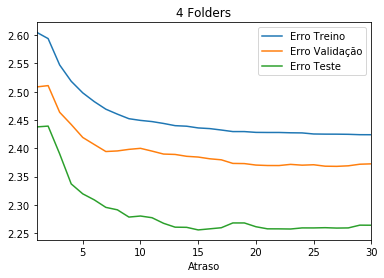

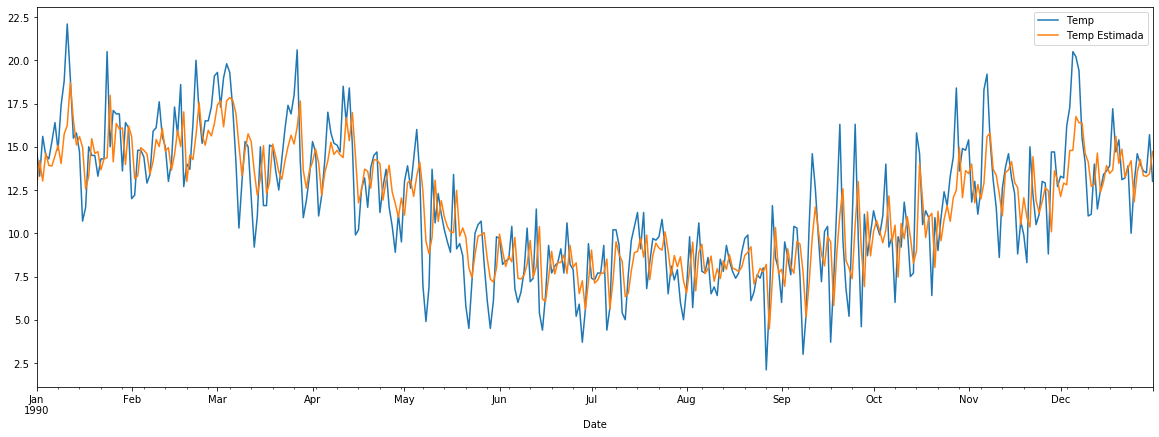

In [7]:
#gera os dados de treino e teste
ano_teste=1990
atrasos=30
lista_folders=[4]
data_train=data_windowed[data_windowed['Year']!=ano_teste].copy()
data_test=data_windowed[data_windowed['Year']==ano_teste].copy()
for folders in lista_folders:
    #inicializa os parâmetros que vão guardar os resultados
    folder_min=0
    k_min=0
    erro_min=0
    erro_antigo=100000
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for f in range(1,folders+1):
        lenght=len(data_train[data_train['fold']==f])
    linha=0
    resultados=pd.DataFrame(columns=['Atraso','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
    y_tf=data_test.iloc[:,2:3].copy()
    for k in range(1,atrasos+1):
        #dados treino globais
        x_tf=data_test.iloc[:,3:k+4].copy()
        for f in range(1,folders+1):
            linha+=1
            resultados.loc[linha,'Atraso']=k
            resultados.loc[linha,'Folder']=f
            #Dados treino no folder
            x_train=data_train[data_train['fold']!=f]
            x_train=x_train.iloc[:,3:k+4].copy()
            y_train=data_train[data_train['fold']!=f]
            y_train=y_train.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Treino']=len(x_train)
            #Dados teste no folder
            x_valid=data_train[data_train['fold']==f]
            x_valid=x_valid.iloc[:,3:k+4].copy()
            y_valid=data_train[data_train['fold']==f]
            y_valid=y_valid.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Validação']=len(x_valid)
            #calculo da inversa
            xtx=(x_train.transpose()).dot(x_train)
            rank=np.linalg.matrix_rank(xtx.values)
            if rank==(k+1):
                message="Sim"
            else:
                message="Não"
            resultados.loc[linha,'Matrix']=message
            #cálculo do vetor w para regressão
            xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
            w=(xtxinv.dot(x_train.transpose())).dot(y_train)
            #erro treino
            yh_train=x_train.dot(w)
            error_train=mt.sqrt(((yh_train-y_train)**2).mean())
            resultados.loc[linha,'Erro Treino']=error_train
            #erro validação
            yh_valid=x_valid.dot(w)
            error_valid=mt.sqrt(((yh_valid-y_valid)**2).mean())
            resultados.loc[linha,'Erro Validação']=error_valid
            #erro global
            yh_tf=x_tf.dot(w)
            error_tf=mt.sqrt(((yh_tf-y_tf)**2).mean())
            resultados.loc[linha,'Erro Teste']=error_tf
            
            if error_valid<erro_antigo:
                erro_min=error_valid
                temp_estimada_min=yh_tf.copy()
                folder_min=f
                k_min=k
                erro_antigo=error_valid
#     print(resultados[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    relatorio_lista=[]
    linha=0
    for k in range(1,atrasos+1):
        linha +=1
        x=resultados[resultados['Atraso']==k].copy()
        x=x.astype({'Erro Validação':float})
        linha_dados=x.loc[x['Erro Validação'].idxmin()]
        relatorio_lista.append(linha_dados.values.tolist())
        
    relatorio=pd.DataFrame(relatorio_lista,columns=['Atraso','Folder','Dado Treino','Dado Teste','Matrix','Erro Treino','Erro Validação','Erro Teste'])
#     print(relatorio[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    print("Relatorio para {} folders.".format(folders))
    linha_dados=relatorio.loc[relatorio['Erro Validação'].idxmin()]
    print("O número de atrasos que gerou o menor erro de validação foi:{}".format(linha_dados['Atraso']))
    print("Erro Treino:{}".format(linha_dados['Erro Treino']))
    print("Erro Validação:{}".format(linha_dados['Erro Validação']))
    print("Erro Teste:{}".format(linha_dados['Erro Teste']))
    print("Folder:{}".format(linha_dados['Folder']))
#     plotando grafico
    relatorio.plot(x='Atraso',y=['Erro Treino','Erro Validação','Erro Teste'])
    title="{} Folders".format(folders)
    ml.pyplot.title(title)
    print(ml.pyplot.show)
    print(folder_min)
    print(k_min)
    print(erro_min)
    grafico=data_test.iloc[:,1:2].copy()
    print(mt.sqrt(((temp_estimada_min-y_tf)**2).mean()))
    grafico['Temp']=y_tf
    grafico['Temp Estimada']=temp_estimada_min
#     print(grafico)
    grafico.plot(x='Date',y=['Temp','Temp Estimada'],figsize=(20,7))
    print(ml.pyplot.show)

Relatorio para 8 folders.
O número de atrasos que gerou o menor erro de validação foi:15
Erro Treino:2.438958851290914
Erro Validação:2.3042046572026265
Erro Teste:2.259314691484464
Folder:6
<function show at 0x0B81EED0>
6
15
2.3042046572026265
2.259314691484464
<function show at 0x0B81EED0>


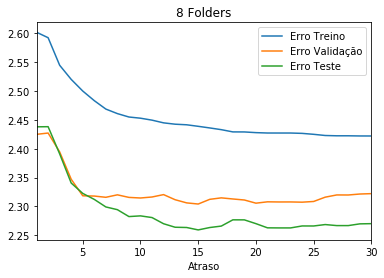

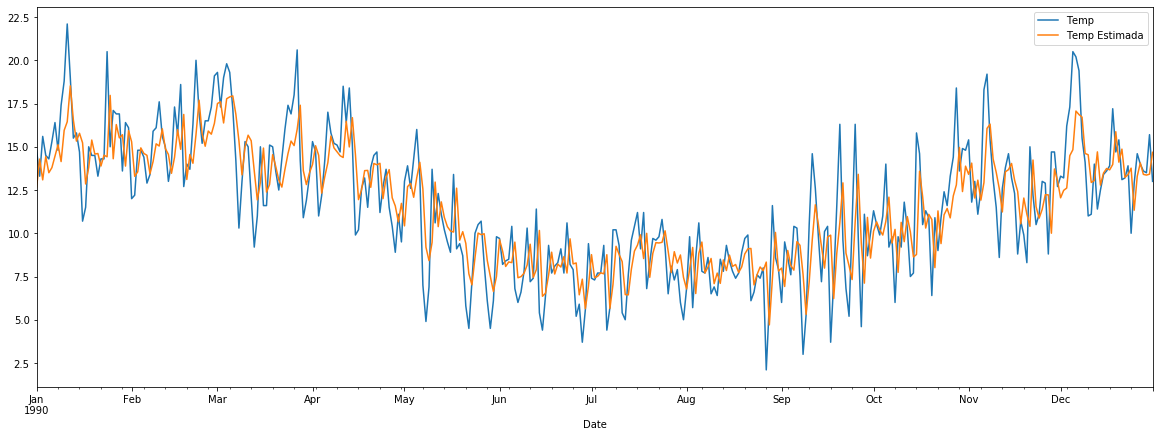

In [20]:
#gera os dados de treino e teste
ano_teste=1990
atrasos=30
lista_folders=[8]
data_train=data_windowed[data_windowed['Year']!=ano_teste].copy()
data_test=data_windowed[data_windowed['Year']==ano_teste].copy()
for folders in lista_folders:
    #inicializa os parâmetros que vão guardar os resultados
    folder_min=0
    k_min=0
    erro_min=0
    erro_antigo=100000
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for f in range(1,folders+1):
        lenght=len(data_train[data_train['fold']==f])
    linha=0
    resultados=pd.DataFrame(columns=['Atraso','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
    y_tf=data_test.iloc[:,2:3].copy()
    for k in range(1,atrasos+1):
        #dados treino globais
        x_tf=data_test.iloc[:,3:k+4].copy()
        for f in range(1,folders+1):
            linha+=1
            resultados.loc[linha,'Atraso']=k
            resultados.loc[linha,'Folder']=f
            #Dados treino no folder
            x_train=data_train[data_train['fold']!=f]
            x_train=x_train.iloc[:,3:k+4].copy()
            y_train=data_train[data_train['fold']!=f]
            y_train=y_train.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Treino']=len(x_train)
            #Dados teste no folder
            x_valid=data_train[data_train['fold']==f]
            x_valid=x_valid.iloc[:,3:k+4].copy()
            y_valid=data_train[data_train['fold']==f]
            y_valid=y_valid.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Validação']=len(x_valid)
            #calculo da inversa
            xtx=(x_train.transpose()).dot(x_train)
            rank=np.linalg.matrix_rank(xtx.values)
            if rank==(k+1):
                message="Sim"
            else:
                message="Não"
            resultados.loc[linha,'Matrix']=message
            #cálculo do vetor w para regressão
            xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
            w=(xtxinv.dot(x_train.transpose())).dot(y_train)
            #erro treino
            yh_train=x_train.dot(w)
            error_train=mt.sqrt(((yh_train-y_train)**2).mean())
            resultados.loc[linha,'Erro Treino']=error_train
            #erro validação
            yh_valid=x_valid.dot(w)
            error_valid=mt.sqrt(((yh_valid-y_valid)**2).mean())
            resultados.loc[linha,'Erro Validação']=error_valid
            #erro global
            yh_tf=x_tf.dot(w)
            error_tf=mt.sqrt(((yh_tf-y_tf)**2).mean())
            resultados.loc[linha,'Erro Teste']=error_tf
            
            if error_valid<erro_antigo:
                erro_min=error_valid
                temp_estimada_min=yh_tf.copy()
                folder_min=f
                k_min=k
                erro_antigo=error_valid
#     print(resultados[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    relatorio_lista=[]
    linha=0
    for k in range(1,atrasos+1):
        linha +=1
        x=resultados[resultados['Atraso']==k].copy()
        x=x.astype({'Erro Validação':float})
        linha_dados=x.loc[x['Erro Validação'].idxmin()]
        relatorio_lista.append(linha_dados.values.tolist())
        
    relatorio=pd.DataFrame(relatorio_lista,columns=['Atraso','Folder','Dado Treino','Dado Teste','Matrix','Erro Treino','Erro Validação','Erro Teste'])
#     print(relatorio[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    print("Relatorio para {} folders.".format(folders))
    linha_dados=relatorio.loc[relatorio['Erro Validação'].idxmin()]
    print("O número de atrasos que gerou o menor erro de validação foi:{}".format(linha_dados['Atraso']))
    print("Erro Treino:{}".format(linha_dados['Erro Treino']))
    print("Erro Validação:{}".format(linha_dados['Erro Validação']))
    print("Erro Teste:{}".format(linha_dados['Erro Teste']))
    print("Folder:{}".format(linha_dados['Folder']))
#     plotando grafico
    relatorio.plot(x='Atraso',y=['Erro Treino','Erro Validação','Erro Teste'])
    title="{} Folders".format(folders)
    ml.pyplot.title(title)
    print(ml.pyplot.show)
    print(folder_min)
    print(k_min)
    print(erro_min)
    grafico=data_test.iloc[:,1:2].copy()
    print(mt.sqrt(((temp_estimada_min-y_tf)**2).mean()))
    grafico['Temp']=y_tf
    grafico['Temp Estimada']=temp_estimada_min
#     print(grafico)
    grafico.plot(x='Date',y=['Temp','Temp Estimada'],figsize=(20,7))
    print(ml.pyplot.show)

In [6]:
for ano in range(1981,1991):
    print(ano)
    data_train=data_windowed[data_windowed['Year']!=ano].copy()
    data_test=data_windowed[data_windowed['Year']==ano].copy()
    x_train=data_train.iloc[:,3:34].copy()
    y_train=data_train['Temp'].copy()
    
    x_test=data_test.iloc[:,3:34].copy()
    y_test=data_test['Temp'].copy()
    
    xtx=(x_train.transpose()).dot(x_train)
    xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
    w=(xtxinv.dot(x_train.transpose())).dot(y_train)
    
    y_train_estimado=(x_train).dot(w)
    error_train=mt.sqrt(((y_train_estimado-y_train)**2).mean())
    print("erro treino {}".format(error_train))
    y_test_estimado=(x_test.values).dot(w.values)
    error_test=mt.sqrt(((y_test_estimado-y_test)**2).mean())
    print("erro teste {}".format(error_test))

1981
erro treino 2.3950733795682644
erro teste 2.395415791820079
1982
erro treino 2.363011701317136
erro teste 2.680088597647611
1983
erro treino 2.382853914906737
erro teste 2.5101078296233683
1984
erro treino 2.3820921201245295
erro teste 2.509802548890509
1985
erro treino 2.3977623829837946
erro teste 2.369084712735388
1986
erro treino 2.3942045020458838
erro teste 2.4049666157759577
1987
erro treino 2.395037705657323
erro teste 2.401123705023188
1988
erro treino 2.391627666183208
erro teste 2.424321801644336
1989
erro treino 2.4198318300660926
erro teste 2.161401117646023
1990
erro treino 2.408973471425526
erro teste 2.2655007149453508


Relatorio para 4 folders.
O número de atrasos que gerou o menor erro de validação foi:21
Erro Treino:2.4006043796966874
Erro Validação:2.3486042817664896
Erro Teste:2.5094083801928426
Folder:3
<function show at 0x0B81EED0>
3
21
2.3486042817664896
2.5094083801928426
<function show at 0x0B81EED0>


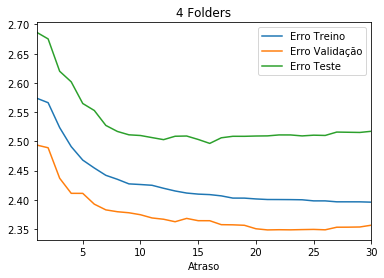

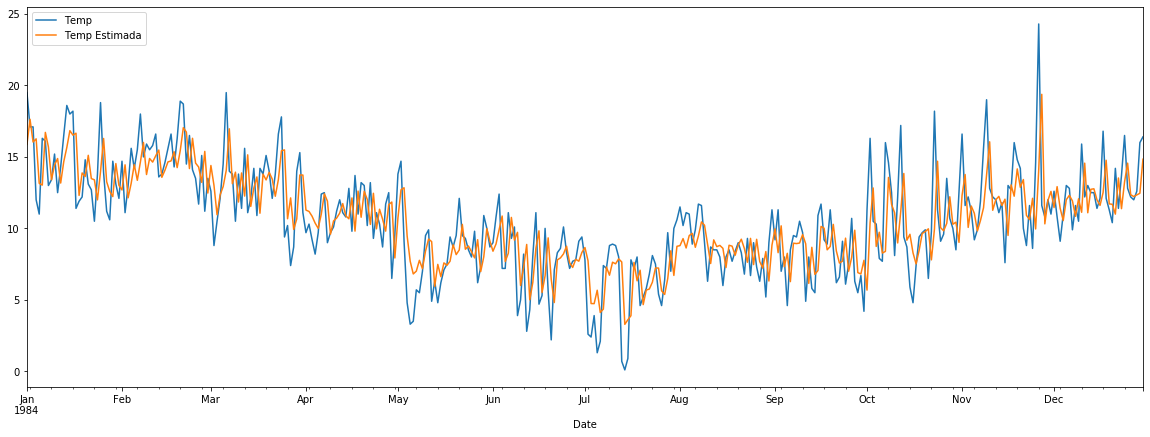

In [45]:
#gera os dados de treino e teste
ano_teste=1984
atrasos=30
lista_folders=[4]
data_train=data_windowed[data_windowed['Year']!=ano_teste].copy()
data_test=data_windowed[data_windowed['Year']==ano_teste].copy()
for folders in lista_folders:
    #inicializa os parâmetros que vão guardar os resultados
    folder_min=0
    k_min=0
    erro_min=0
    erro_antigo=100000
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for f in range(1,folders+1):
        lenght=len(data_train[data_train['fold']==f])
    linha=0
    resultados=pd.DataFrame(columns=['Atraso','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
    y_tf=data_test.iloc[:,2:3].copy()
    for k in range(1,atrasos+1):
        #dados treino globais
        x_tf=data_test.iloc[:,3:k+4].copy()
        for f in range(1,folders+1):
            linha+=1
            resultados.loc[linha,'Atraso']=k
            resultados.loc[linha,'Folder']=f
            #Dados treino no folder
            x_train=data_train[data_train['fold']!=f]
            x_train=x_train.iloc[:,3:k+4].copy()
            y_train=data_train[data_train['fold']!=f]
            y_train=y_train.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Treino']=len(x_train)
            #Dados teste no folder
            x_valid=data_train[data_train['fold']==f]
            x_valid=x_valid.iloc[:,3:k+4].copy()
            y_valid=data_train[data_train['fold']==f]
            y_valid=y_valid.iloc[:,2:3].copy()
            resultados.loc[linha,'Dado Validação']=len(x_valid)
            #calculo da inversa
            xtx=(x_train.transpose()).dot(x_train)
            rank=np.linalg.matrix_rank(xtx.values)
            if rank==(k+1):
                message="Sim"
            else:
                message="Não"
            resultados.loc[linha,'Matrix']=message
            #cálculo do vetor w para regressão
            xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
            w=(xtxinv.dot(x_train.transpose())).dot(y_train)
            #erro treino
            yh_train=x_train.dot(w)
            error_train=mt.sqrt(((yh_train-y_train)**2).mean())
            resultados.loc[linha,'Erro Treino']=error_train
            #erro validação
            yh_valid=x_valid.dot(w)
            error_valid=mt.sqrt(((yh_valid-y_valid)**2).mean())
            resultados.loc[linha,'Erro Validação']=error_valid
            #erro global
            yh_tf=x_tf.dot(w)
            error_tf=mt.sqrt(((yh_tf-y_tf)**2).mean())
            resultados.loc[linha,'Erro Teste']=error_tf
            
            if error_valid<erro_antigo:
                erro_min=error_valid
                temp_estimada_min=yh_tf.copy()
                folder_min=f
                k_min=k
                erro_antigo=error_valid
#     print(resultados[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    relatorio_lista=[]
    linha=0
    for k in range(1,atrasos+1):
        linha +=1
        x=resultados[resultados['Atraso']==k].copy()
        x=x.astype({'Erro Validação':float})
        linha_dados=x.loc[x['Erro Validação'].idxmin()]
        relatorio_lista.append(linha_dados.values.tolist())
        
    relatorio=pd.DataFrame(relatorio_lista,columns=['Atraso','Folder','Dado Treino','Dado Teste','Matrix','Erro Treino','Erro Validação','Erro Teste'])
#     print(relatorio[['Atraso','Folder','Erro Treino','Erro Validação','Erro Teste']])
    print("Relatorio para {} folders.".format(folders))
    linha_dados=relatorio.loc[relatorio['Erro Validação'].idxmin()]
    print("O número de atrasos que gerou o menor erro de validação foi:{}".format(linha_dados['Atraso']))
    print("Erro Treino:{}".format(linha_dados['Erro Treino']))
    print("Erro Validação:{}".format(linha_dados['Erro Validação']))
    print("Erro Teste:{}".format(linha_dados['Erro Teste']))
    print("Folder:{}".format(linha_dados['Folder']))
#     plotando grafico
    relatorio.plot(x='Atraso',y=['Erro Treino','Erro Validação','Erro Teste'])
    title="{} Folders".format(folders)
    ml.pyplot.title(title)
    print(ml.pyplot.show)
    print(folder_min)
    print(k_min)
    print(erro_min)
    grafico=data_test.iloc[:,1:2].copy()
    print(mt.sqrt(((temp_estimada_min-y_tf)**2).mean()))
    grafico['Temp']=y_tf
    grafico['Temp Estimada']=temp_estimada_min
#     print(grafico)
    grafico.plot(x='Date',y=['Temp','Temp Estimada'],figsize=(20,7))
    print(ml.pyplot.show)